In [1]:
import torch
print(torch.__version__)
from datasets.dataset import RandomPatchFromFolder
from utils.visualization import visualize_one, visualize_pairs, visualize_triplets
from models.blocks import Generator, Discriminator, FeatureExtractor
import torchvision

from utils.metrics import psnr
from utils import utils
%pylab inline

0.4.1
Populating the interactive namespace from numpy and matplotlib


In [2]:
train_dataset = RandomPatchFromFolder("data/div2k/train")

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    shuffle=True,
    pin_memory=True,
    batch_size=16,
    num_workers=4)

In [3]:
x, y = train_dataset[0]

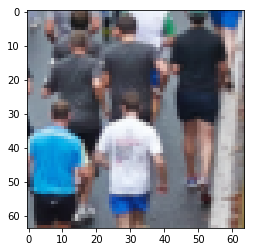

In [4]:
plt.imshow(RandomPatchFromFolder.to_image(x))

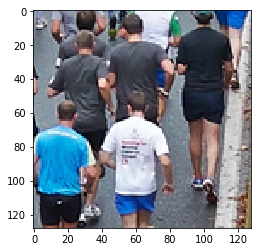

In [5]:
plt.imshow(RandomPatchFromFolder.to_image(y))

In [ ]:
class Sequential(torch.nn.Module):
    def __init__(self, *sequence):
        super(Sequential, self).__init__()
        self.model = torch.nn.Sequential(*sequence)
        self.model.train()
        
    def forward(self, x):
        x = self.model.forward(x)
        return x

    def predict(self, x):
        self.model.eval()
        with torch.no_grad():
            x = self.model.forward(x)
        self.model.train()
        return x.detach().cpu()

In [6]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

cuda:0


In [ ]:
class Generator(torch.nn.Module):
    def __init__(self, n_residuals, upsample):
        super(Generator, self).__init__()
        self.n_residuals = n_residuals
        self.upsample = upsample

        self.pre_conv = ConvBlock(3, 64, 9)

        self.residual_seq = torch.nn.Sequential(*[ResidualBlock(64, 64, 3) for i in range(n_residuals)])

        self.upconv = UpConvBlock(64, 64, 5)
        self.post_conv = ConvBlock(64, 3, 5, activation=torch.nn.Tanh)

    def forward(self, x):
        out = self.pre_conv(x)
        out = self.residual_seq(out)
        out = self.upconv(out)
        out = self.post_conv(out)
        return out 

In [ ]:
class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.pre_conv = ConvBlock(3, 64, 3)

        self.stride_conv1 = ConvBlock(64, 64, 3, stride=2)
        self.deepen_conv1 = ConvBlock(64, 128, 3)

        self.stride_conv2 = ConvBlock(128, 128, 3, stride=2)
        self.deepen_conv2 = ConvBlock(128, 256, 3)

        self.stride_conv3 = ConvBlock(256, 256, 3, stride=2)
        self.deepen_conv3 = ConvBlock(256, 512, 3)

        self.stride_conv4 = ConvBlock(512, 512, 3, stride=2)
        self.deepen_conv4 = ConvBlock(512, 512, 3)
        
    def forward(self, x):
        out = self.pre_conv(x)

        out = self.deepen_conv1(self.stride_conv1(out))
        out = self.deepen_conv2(self.stride_conv2(out))
        out = self.deepen_conv3(self.stride_conv3(out))
        out = self.deepen_conv4(self.stride_conv4(out))

        out = F.sigmoid(F.avg_pool3d(out, out.size()))
        return out

In [7]:
generator = Generator(n_residuals=2, upsample=2).to(device)
discriminator = Discriminator().to(device)

feature_extractor = FeatureExtractor(torchvision.models.vgg19(pretrained=True))

In [8]:
content_criterion = torch.nn.MSELoss()
adversarial_criterion = torch.nn.BCELoss()

In [ ]:
# pre-train generator
generator_optimizer = optim.Adam(generator.parameters())

for epoch in range(2):
    print("Epoch {} started".format(epoch))
    generator.train()
    for i, (lr, hr) in enumerate(train_loader):
        generator_optimizer.zero_grad()
        
        batch_lr = lr.to(device)
        batch_hr = hr.to(device)
        
        batch_generated = generator.forward(batch_lr)

        loss = content_criterion(batch_generated, batch_hr)
        loss.backward()
        generator_optimizer.step()
        
        if i % 25 == 0:
            torch.save(generator.state_dict(), "generator_state_dict.wght")
            err = loss.item()
#             errs.append(err)
            
            metric = psnr(err)
#             metrics.append(metric)
            print("Batch {} loss {}, ".format(i, err), end="")
            print("PSNR: {}".format(metric))

In [ ]:
#train GAN
generator_optimizer = optim.Adam(generator.parameters())
discriminator_optimizer = optim.Adam(discriminator.parameters())

# gan_errs, gan_metrics = list(), list()

const_positive = 0.9*torch.ones((16, 1))
const_negative = 1 - const_positive

for epoch in range(2):
    print("Epoch {} started".format(epoch))
    generator.train()
    discriminator.train()
    for i, (lr, hr) in enumerate(train_loader):
        batch_lr = lr.to(device)
        batch_real = hr.to(device)

        batch_fake = generator.forward(batch_lr)
        
        # const_ones, const_zeros
        
        # train discriminator
        discriminator_optimizer.zero_grad()
        
        discriminator_loss = adversarial_criterion(discriminator(batch_real), const_positive)
        discriminator_loss += adversarial_criterion(discriminator(batch_fake), const_negative)
        discriminator_loss.backward()
        
        discriminator_optimizer.step()
        
        # train generator
        batch_real_features = feature_extractor(batch_real)
        batch_fake_features = feature_extractor(batch_fake)
        
        generator_loss = content_criterion(batch_fake, batch_real)
        generator_loss += 0.1 * content_criterion(batch_fake_features, batch_real_features)
        generator_loss.backward()
        
        generator_optimizer.step() 
        
        if i % 25 == 0:
            torch.save(generator.state_dict(), "generator_state_dict.wght")
            torch.save(discriminator.state_dict(), "discriminator_state_dict.wght")
            err = generator_loss.item()
#             errs.append(err)
            
            metric = psnr(err)
#             metrics.append(metric)
            print("Batch {} generator loss {}, ".format(i, err), end="")
            print("PSNR: {}".format(metric))